In [2]:
# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn as sk
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram, cophenet
from sklearn.cluster import AgglomerativeClustering

import umap
import umap.plot

#import gower # calcula matriz de distancias gower
import fastcluster # mejora la performance del cluster jerárquico

# para gridsearch
# https://genieclust.gagolewski.com/
# https://doi.org/10.1016/j.softx.2021.100722
# import genieclust

# for everything else
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# trabajo con zip
#from zipfile import ZipFile
#from io import BytesIO

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)


In [4]:

def grafico_evaluacion(X_train_test, labels_orig, labels_test , nom_test=''):
    '''grafico en el espacio vectorial del pca las clasificaciones realizadas
    X_train_test = coordenadas de lso puntos en PCA -considera slo las primeras 4-
    labels_orig  = etiquetas originales - reales
    labels_test  = etiquetas halladeas por el algoritmo
    nom_test     = texto para aclara en el grafico el nombre del clasificador utilizado
    '''
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(1,2, figsize=(4,2))
    axs[0].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_test, alpha=0.5, cmap=cmap)
            
    axs[1].scatter(X_train_test[:,0],X_train_test[:,1],s=0.5,c=labels_orig, alpha=0.5, cmap=cmap)
    
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title(f'{nom_test}')
    axs[1].set_title('real')
    fig.set_constrained_layout('constrained')
    return None


def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

def cross_tab(Labels_orig, Labels_clust):
     '''crea matriz de confusión para evaluar etiquetado
     labels_orig  = etiquetas originales - reales
     labels_test  = etiquetas halladeas por el algoritmo'''
     tmp = pd.DataFrame({'Labels_orig': Labels_orig, 'Labels_clust': Labels_clust})
     ct = pd.crosstab(tmp['Labels_clust'],tmp['Labels_orig']) # Create crosstab: ct
     rand = metrics.rand_score(Labels_orig, Labels_clust)
     arand= metrics.adjusted_rand_score(Labels_orig, Labels_clust)
     vandon =vanDongen(ct)
     print(f'RAND score={rand:.4f}, Ajusted RAND={arand:.4f}, vanDongen={vandon:.4f} cantidad_de_muestras={len(Labels_orig):,d}')
     return ct, rand, arand, vandon



In [5]:
def leo_y_consolido_features(input_path='./input/'):
    df1 = pd.read_csv(input_path+'features_Arborio.csv')
    df2 = pd.read_csv(input_path+'features_Basmati.csv')
    df3 = pd.read_csv(input_path+'features_Ipsala.csv')
    df4 = pd.read_csv(input_path+'features_Jasmine.csv')
    df5 = pd.read_csv(input_path+'features_Karacadag.csv')
    features = np.array(pd.concat([df1,df2,df3,df4,df5], axis =0))
    return features
    
def paso_a_pca(features, guardo=False, archivo_guarda=None):
    # reduce the amount of dimensions in the feature vector
    pca = PCA(n_components=100, random_state=22)
    pca.fit(features)
    x = pca.transform(features)
    if guardo:
        archivo_pca = archivo_guarda
        pd.DataFrame(x).to_csv(archivo_pca, index=False)
    # grafico varianza explicada
    ax = plt.subplot()
    ax.plot(100*pca.explained_variance_ / sum(pca.explained_variance_),'.-')
    ax.set_xlim([0,15])
    ax.set_xlabel('PCs')
    ax.set_ylabel('Var. explicada (%)')
    return x

ARCHIVO_PCA = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/feat_pca.csv'
ARCHIVO_UMAP = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/feat_umap.csv'

INPUT_P = 'C:/Users/jfgonzalez/Documents/Documentación_maestría/Ciencia_y_tecnologia/unsupervised-rice-image-segmentation/input/'

ARCHIVO_PCA = './output/feat_pca.csv'
ARCHIVO_UMAP = './output/feat_umap.csv'
INPUT_P = './input/'

# como están ordenadas por clase voy a hacer una lista con las etiquetas ahora antes de mezclarlas
clases_dict = {0:'Arborio', 1:'Basmati', 2:'Ipsala', 3:'Jasmine', 4:'Karacadag'}
lista_clases = ([0]*15000 + [1]*15000 + [2]*15000 + [3]*15000 + [4]*15000)
org_lab = pd.Series(lista_clases).map(clases_dict)

In [6]:
#x = paso_a_pca(leo_y_consolido_features(input_path=INPUT_P),
#                guardo=True, archivo_guarda=ARCHIVO_PCA)
x = pd.read_csv(ARCHIVO_PCA).to_numpy()

In [7]:
#Realizo UMAP reducción de dimensiones desde pca con UMAP y clasifico
# min_dist=0.0 better for clustering
# n_neighbors=20
# x_umap = umap.UMAP(n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean', random_state=42)
# umap_2d = x_umap.fit_transform(leo_y_consolido_features(input_path=INPUT_P))
# umap.plot.points(x_umap, labels = org_lab, theme='red')

#umap_2d = pd.DataFrame(umap_2d)
#umap_2d.to_csv(ARCHIVO_UMAP, index=False)

x_umap = pd.read_csv(ARCHIVO_UMAP).to_numpy()

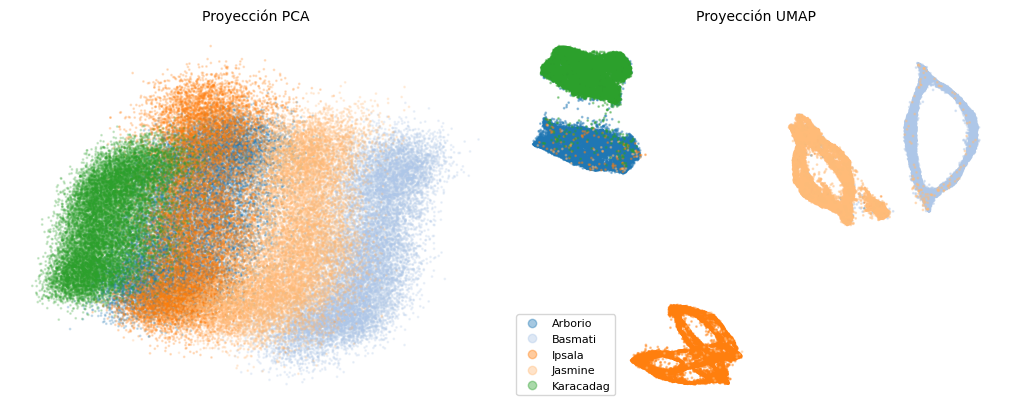

In [83]:

def grafico_comparacion_proyecciones(x, x_umap, labels_orig, guardo=False):
       
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', plt.cm.tab20(np.arange(5)), 5)

    fig, axs = plt.subplots(1,2, figsize=(10,4))
    p1 = axs[0].scatter(x[:,0],x[:,1],s=1, c=labels_orig, alpha=0.2, cmap=cmap)
    
    p2 = axs[1].scatter(x_umap[:,0],x_umap[:,1],s=1, c=labels_orig, alpha=0.4, cmap=cmap)
    
    axs[0].axis('off')
    axs[1].axis('off')
    #axs[2].axis('off')
    axs[0].set_title('Proyección PCA', fontsize=10)
    axs[1].set_title('Proyección UMAP', fontsize=10)
    fig.set_constrained_layout('constrained')
    # fig.subplots_adjust(bottom=0.1)
    handles, labels = axs[1].get_legend_handles_labels()
    #labels.map(clases_dict)
    L = axs[1].legend(*p2.legend_elements(), fontsize=8)
    L.get_texts()[0].set_text('Arborio')
    L.get_texts()[1].set_text('Basmati')
    L.get_texts()[2].set_text('Ipsala')
    L.get_texts()[3].set_text('Jasmine')
    L.get_texts()[4].set_text('Karacadag')
    
    if guardo:
        plt.savefig('comparacion_proyecciones.png')
    return 
grafico_comparacion_proyecciones(x, x_umap, lista_clases, guardo=True)


In [7]:

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    colors = plt.cm.tab20(np.arange(6))
    dendrogram(linkage_matrix, **kwargs)
    return linkage_matrix

#%%
def dendro(hclust, color_threshold=150  ):
    fig = plt.figure(figsize=(15,4))
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top three levels of the dendrogram
    linkage_matrix = plot_dendrogram(hclust, p=3, leaf_rotation=45, truncate_mode="level", color_threshold=color_threshold)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    return linkage_matrix


In [8]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo
#  x      75000 x 100 features de PCA
#  x_umap 75000 x 2 features de UMAP

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_pca, X_val_pca, y_pca, y_val_pca = sk.model_selection.train_test_split(x, lista_clases, test_size=0.2, random_state=42)
X_umap, X_val_umap, y_umap, y_val_umap = sk.model_selection.train_test_split(x_umap, lista_clases, test_size=0.2, random_state=42)

org_lab = pd.Series(y_pca).map(clases_dict)

In [39]:
y_pca==y_umap

True

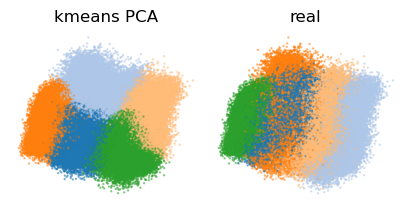

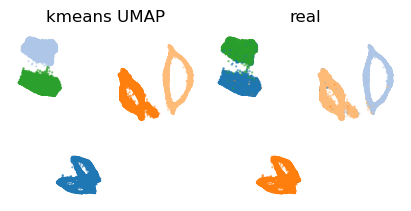

In [9]:
# aplico kmeans, esto porque es rápido y me sirve de punto de comparación

#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_p = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_p.fit(X_pca)

grafico_evaluacion(X_pca, y_pca, kmeans_p.labels_ , nom_test='kmeans PCA')

#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_u = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_u.fit(X_umap)

grafico_evaluacion(X_umap, y_umap, kmeans_u.labels_ , nom_test='kmeans UMAP')

In [10]:
# calculo para PCA
hclust_pca = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500 )
label_pca = hclust_pca.fit_predict(X_pca)

# calculo para UMAP
hclust_umap = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350 )
label_umap = hclust_umap.fit_predict(X_umap)

In [11]:
print('AgglomerativeClustering', "n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500")
ct_hc_pca = cross_tab(org_lab, hclust_pca.labels_)
print()
print('AgglomerativeClustering UMAP') 
print('AgglomerativeClustering params:',"n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_hc_umap = cross_tab(org_lab, hclust_umap.labels_)
print()
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
ct_km_pca = cross_tab(org_lab, kmeans_p.labels_)
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_km_umap = cross_tab(org_lab, kmeans_u.labels_)

AgglomerativeClustering n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500
RAND score=0.8254, Ajusted RAND=0.4689, vanDongen=0.4629 cantidad_de_muestras=60,000

AgglomerativeClustering UMAP
AgglomerativeClustering params: n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350
UMAP params: n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean
RAND score=0.9873, Ajusted RAND=0.9603, vanDongen=0.0202 cantidad_de_muestras=60,000

Kmeans params: n_clusters=5, n_init='auto', random_state=42, init='k-means++'
RAND score=0.8131, Ajusted RAND=0.4191, vanDongen=0.4807 cantidad_de_muestras=60,000
Kmeans params: n_clusters=5, n_init='auto', random_state=42, init='k-means++'
UMAP params: n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean
RAND score=0.9873, Ajusted RAND=0.9603, vanDongen=0.0202 cantidad_de_muestras=60,000


In [12]:
stats = pd.concat([pd.DataFrame(ct_km_pca[1:]), pd.DataFrame(ct_km_umap[1:]),  pd.DataFrame(ct_hc_pca[1:]), 
                   pd.DataFrame(ct_hc_umap[1:])], axis=1)
stats.columns = ['ct_km_pca', 'ct_km_umap','ct_hc_pca','ct_hc_umap']
stats = stats.T
stats.columns = ['RAND', 'ARAND', 'VanDon']

In [13]:
stats

,RAND,ARAND,VanDon
ct_km_pca,0.813102,0.419104,0.480661
ct_km_umap,0.987290,0.960281,0.020215
ct_hc_pca,0.825430,0.468859,0.462924
ct_hc_umap,0.987289,0.960280,0.020215


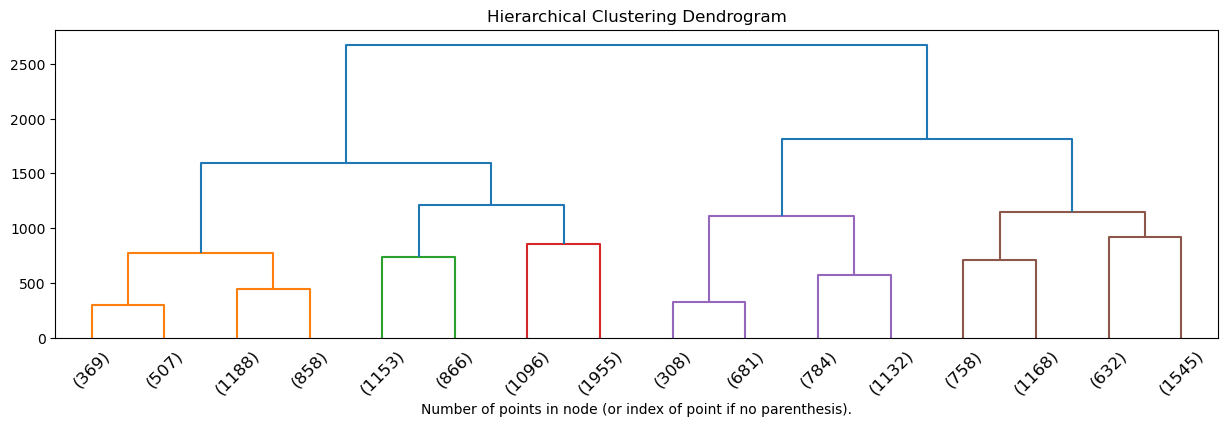

In [32]:
# dendrograma desde PCA
mx_pca = dendro(hclust_pca, color_threshold=2500, )

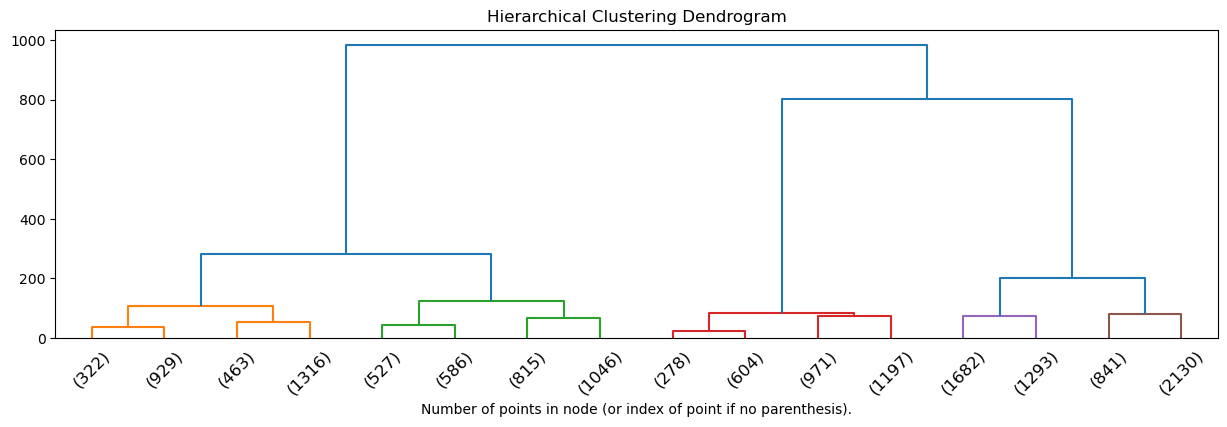

In [29]:
# dendrograma desde UMAP
mx_umap = dendro(hclust_umap, color_threshold=350)

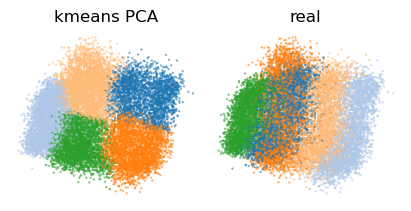

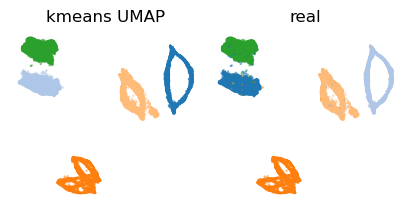

In [17]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo
#  x      75000 x 100 features de PCA
#  x_umap 75000 x 2 features de UMAP

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
# X_pca, X_val_pca, y_pca, y_val_pca = sk.model_selection.train_test_split(x, lista_clases, test_size=0.2, random_state=42)
# X_umap, X_val_umap, y_umap, y_val_umap = sk.model_selection.train_test_split(x_umap, lista_clases, test_size=0.2, random_state=42)

org_lab = pd.Series(y_val_pca).map(clases_dict)


#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_p = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_p.fit(X_val_pca)

grafico_evaluacion(X_val_pca, y_val_pca, kmeans_p.labels_ , nom_test='kmeans PCA')

#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_u = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_u.fit(X_val_umap)

grafico_evaluacion(X_val_umap, y_val_umap, kmeans_u.labels_ , nom_test='kmeans UMAP')


In [33]:

# calculo para PCA
hclust_pca = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=1200 )
label_pca = hclust_pca.fit_predict(X_val_pca)

# calculo para UMAP
hclust_umap = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=200 )
label_umap = hclust_umap.fit_predict(X_val_umap)


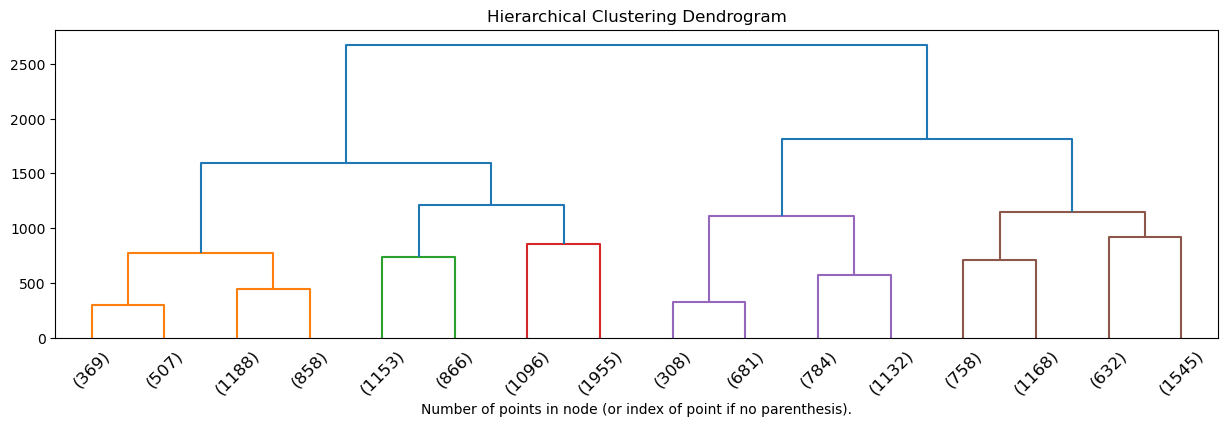

In [32]:
# dendrograma desde PCA
mx_pca = dendro(hclust_pca, color_threshold=1200, )

In [55]:
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import pdist, squareformc
Z = single(pdist(hclust_umap.children_))
c_z = cophenet(Z, pdist(hclust_umap.children_))
Q = squareform(c_z)

array([[1.27000000e+04, 1.30970000e+04, 1.41421356e+00, 2.00000000e+00],
       [1.49550000e+04, 1.49600000e+04, 1.41421356e+00, 2.00000000e+00],
       [1.49780000e+04, 1.49790000e+04, 1.41421356e+00, 2.00000000e+00],
       ...,
       [1.39340000e+04, 2.99930000e+04, 1.18476031e+03, 1.49940000e+04],
       [2.99740000e+04, 2.99940000e+04, 1.21590296e+03, 1.49960000e+04],
       [2.99840000e+04, 2.99950000e+04, 1.21788752e+03, 1.49990000e+04]])

In [70]:
Z_u = single(pdist(hclust_pca.children_))
c_z_u = cophenet(Z_u, pdist(hclust_pca.children_))


In [71]:
c_z_u[0]

0.07979289859933944

In [69]:
c_z[0]

0.10055656263399157

In [67]:
c_z = cophenet(Z, pdist(hclust_umap.children_))

In [68]:
c_z

(0.10055656263399157,
 array([166.62832892, 163.8780034 , 166.62832892, ...,   1.41421356,
          4.24264069,   4.24264069]))

In [59]:
Q = squareform(c_z)

<Axes: >

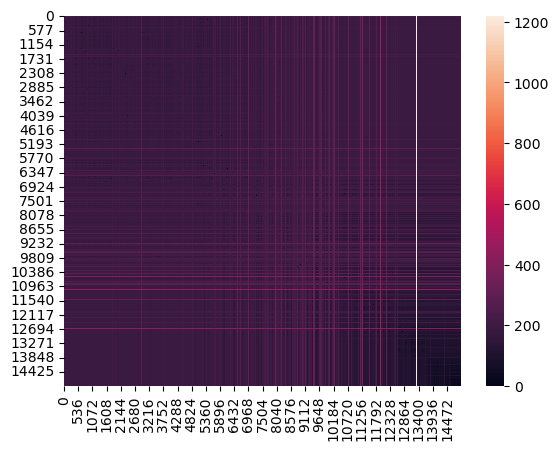

In [61]:
import seaborn as sns
sns.heatmap(Q)

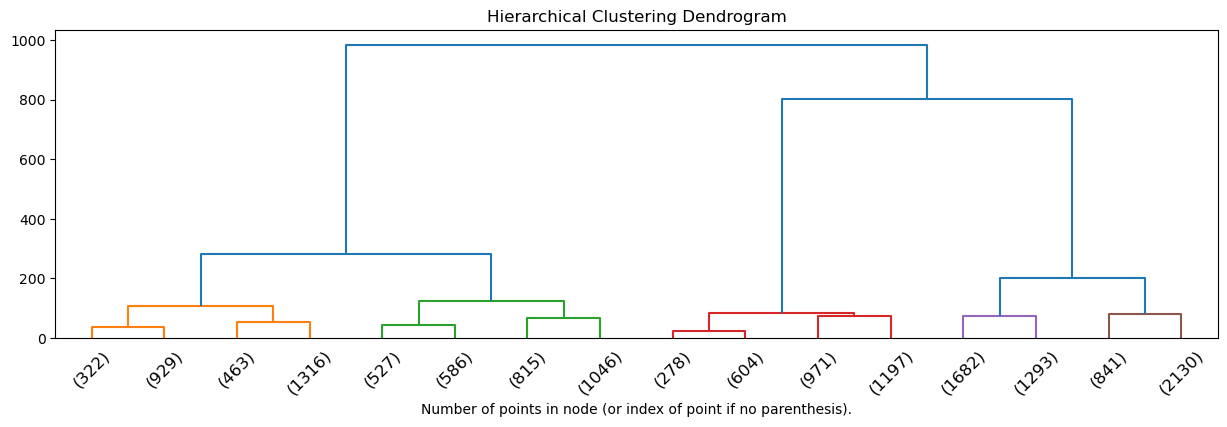

In [29]:
# dendrograma desde UMAP
mx_umap = dendro(hclust_umap, color_threshold=200)



In [35]:

print('AgglomerativeClustering', "n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500")
ct_hc_pca = cross_tab(org_lab, hclust_pca.labels_)
print()
print('AgglomerativeClustering UMAP') 
print('AgglomerativeClustering params:',"n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_hc_umap = cross_tab(org_lab, hclust_umap.labels_)
print()
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
ct_km_pca = cross_tab(org_lab, kmeans_p.labels_)
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_km_umap = cross_tab(org_lab, kmeans_u.labels_)


AgglomerativeClustering n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500
RAND score=0.8671, Ajusted RAND=0.5922, vanDongen=0.3237 cantidad_de_muestras=15,000

AgglomerativeClustering UMAP
AgglomerativeClustering params: n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350
UMAP params: n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean
RAND score=0.9886, Ajusted RAND=0.9644, vanDongen=0.0182 cantidad_de_muestras=15,000

Kmeans params: n_clusters=5, n_init='auto', random_state=42, init='k-means++'
RAND score=0.8061, Ajusted RAND=0.3962, vanDongen=0.5301 cantidad_de_muestras=15,000
Kmeans params: n_clusters=5, n_init='auto', random_state=42, init='k-means++'
UMAP params: n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean
RAND score=0.9886, Ajusted RAND=0.9644, vanDongen=0.0182 cantidad_de_muestras=15,000


In [37]:
stats2 = pd.concat([pd.DataFrame(ct_km_pca[1:]), pd.DataFrame(ct_km_umap[1:]),  pd.DataFrame(ct_hc_pca[1:]), 
                   pd.DataFrame(ct_hc_umap[1:])], axis=1)
stats2.columns = ['ct_km_pca_02', 'ct_km_umap_02','ct_hc_pca_02','ct_hc_umap_02']
stats2 = stats2.T
stats2.columns = ['RAND', 'ARAND', 'VanDon']

In [38]:
stats2

,RAND,ARAND,VanDon
ct_km_pca_02,0.806116,0.396239,0.530132
ct_km_umap_02,0.988616,0.964424,0.018184
ct_hc_pca_02,0.867134,0.592218,0.323661
ct_hc_umap_02,0.988616,0.964424,0.018184


In [ ]:
# divido dataset hay que considerar el tamaño según el método porque algunos toman mucho tiempo
#  x      75000 x 100 features de PCA
#  x_umap 75000 x 2 features de UMAP

# separo en train_test y validación con sus respectivas etiquetas y los mezclo
X_pca, X_val_pca, y_pca, y_val_pca = sk.model_selection.train_test_split(x, lista_clases, test_size=0.2, random_state=42)
X_umap, X_val_umap, y_umap, y_val_umap = sk.model_selection.train_test_split(x_umap, lista_clases, test_size=0.2, random_state=42)

org_lab = pd.Series(y_pca).map(clases_dict)


#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_p = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_p.fit(X_pca)

grafico_evaluacion(X_pca, y_pca, kmeans_p.labels_ , nom_test='kmeans PCA')

#kmeans = KMeans(n_clusters=len(unique_labels))
kmeans_u = KMeans(n_clusters=5, n_init='auto', random_state=42, init='k-means++')
kmeans_u.fit(X_umap)

grafico_evaluacion(X_umap, y_umap, kmeans_u.labels_ , nom_test='kmeans UMAP')

# calculo para PCA
hclust_pca = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500 )
label_pca = hclust_pca.fit_predict(X_pca)

# calculo para UMAP
hclust_umap = AgglomerativeClustering(n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350 )
label_umap = hclust_umap.fit_predict(X_umap)


In [ ]:

print('AgglomerativeClustering', "n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=2500")
ct_hc_pca = cross_tab(org_lab, hclust_pca.labels_)
print()
print('AgglomerativeClustering UMAP') 
print('AgglomerativeClustering params:',"n_clusters=None, linkage='ward', compute_distances=True, distance_threshold=350")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_hc_umap = cross_tab(org_lab, hclust_umap.labels_)
print()
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
ct_km_pca = cross_tab(org_lab, kmeans_p.labels_)
print('Kmeans params:',"n_clusters=5, n_init='auto', random_state=42, init='k-means++'")
print('UMAP params:', "n_neighbors=20, min_dist=0.0, n_components=2, metric='euclidean")
ct_km_umap = cross_tab(org_lab, kmeans_u.labels_)
stats = pd.concat([pd.DataFrame(ct_km_pca[1:]), pd.DataFrame(ct_km_umap[1:]),  pd.DataFrame(ct_hc_pca[1:]), 
                   pd.DataFrame(ct_hc_umap[1:])], axis=1)
stats.columns = ['ct_km_pca', 'ct_km_umap','ct_hc_pca','ct_hc_umap']
stats = stats.T
stats.columns = ['RAND', 'ARAND', 'VanDon']

In [ ]:
stats